In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import sparse
from scipy.sparse.linalg import spsolve

%matplotlib inline

In [2]:
# Load and prepare data
data = pd.read_csv("../../data/cyclohexane.csv", header=0)

X = data.drop("solvent", axis=1)
best_sample = X.iloc[0].to_numpy().reshape(-1, 1)

In [3]:
plt.rcParams['font.size'] = 12
def build_plot():
    xticks = np.linspace(0, X.shape[1]-1, 6, dtype=int)
    xlabels = X.columns[xticks].astype(float).astype(int).values

    fig, ax = plt.subplots(figsize=(8, 4))
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['top'].set_color('none')
    plt.ylabel("Intensity (a.u)")
    plt.xlabel("Raman Shift (cm$^{-1}$)")
    plt.xlim([-20, 3296])
    plt.xticks(xticks, labels=xlabels)
    plt.grid(False)
    return fig

## Example Raw Spectra

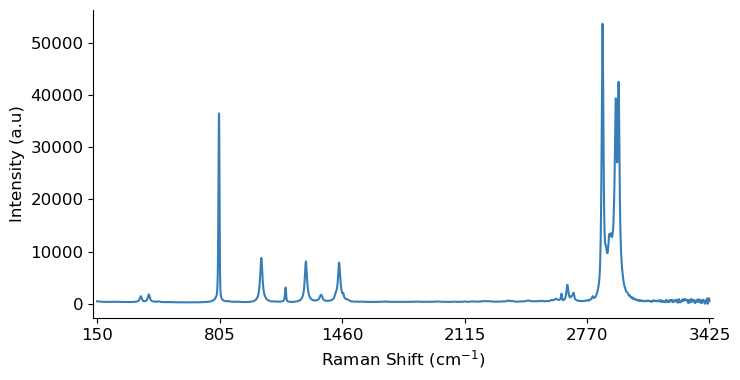

In [4]:
_ = build_plot()
plt.plot(best_sample, "#377eb8");

## Example Batch of Raw Spectra

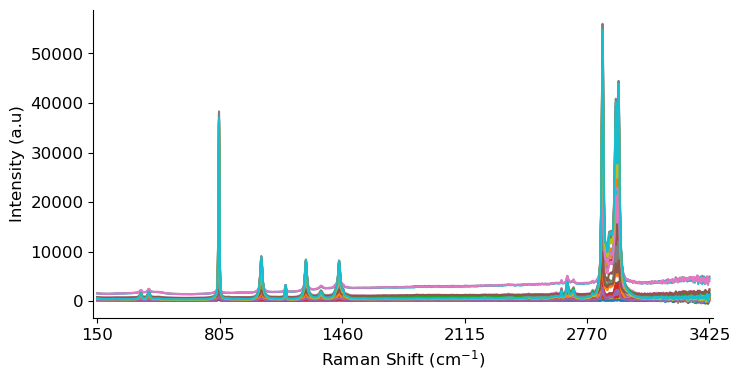

In [5]:
_ = build_plot()
plt.plot(X.iloc[:50, :].T); # semicolon to suppress matplotlib output, can also assign it as _ = plot(.)

## Baseline Correction

Baseline correction is required in Raman spectroscopy to remove background fluorescence effects and other non-sample related spectral noise. It can be done using several methods ranging from simple methods such as polynomial fitting or Savitzky-Golay filters, moderate baselines correction methods like Asymmetric Least Squares (ALS), Whittaker Smoothing, and the Rolling Ball algorithm, or more advanced approaches like wavelet transforms and deep learning models. The *scatter_correction* notebook in this directory provides examples of the Standard Normal Variate and Multiplicative Signal Correction algorithms, which can both be applied to perform baseline correction. Similarly, the *detrending* notebook provides an example of the Savitzky-Golay filter. Here, the cyclohexane spectra do not suffer from complex fluorescence, so first we apply a simple linear polynomial fitting and baseline subtraction, which is not sufficient and requires some tuning. Test the degree parameter below to visualise how it estimates the baseline in increasing complexity as the degree value increases also.

In [6]:
# Baseline correction
def polynomial_baseline_correction(x, y, degree=2):
    """
    Perform baseline correction using polynomial fitting.

    Parameters:
    x : array-like
        Raman shift values.
    y : array-like
        Intensity values.
    degree : int
        Degree of the polynomial fit.

    Returns:
    corrected_y : array-like
        Baseline-corrected intensity values.
    baseline : array-like
        Fitted baseline.
    """
    # Fit a polynomial to the baseline
    coefficients = np.polyfit(x, y, degree)
    baseline = np.polyval(coefficients, x)
    
    # Subtract baseline from the original spectrum
    corrected_y = y - baseline
    
    return corrected_y, baseline

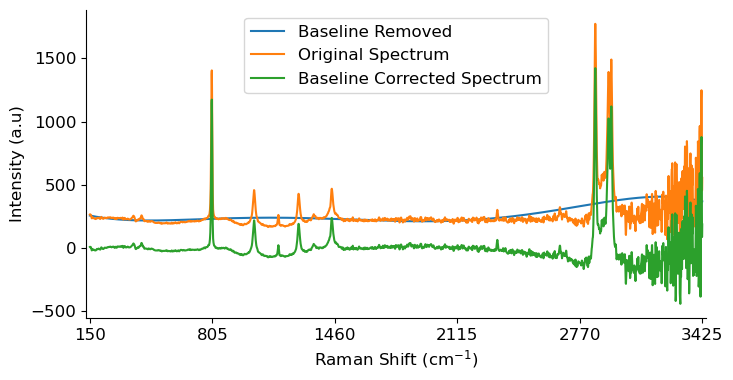

In [7]:
low_intensity_sample = X.iloc[10, :]
raman_shift_values = X.columns.values.astype(float)

# Perform baseline correction
corrected_y, baseline = polynomial_baseline_correction(raman_shift_values, low_intensity_sample, degree=5)

_ = build_plot()
plt.plot(baseline, label="Baseline Removed");
plt.plot(low_intensity_sample, label="Original Spectrum");
plt.plot(corrected_y, label="Baseline Corrected Spectrum");
plt.legend();

Next, we apply the original Asymmetric Least Squares baseline correction. ALS attempts to remove background interference while preserving the spectral features. It works by fitting a smooth baseline to the spectrum using an optimisation approach that balances a smoothness factor and an asymmetry constraint. The baseline (b) is estimated by minimizing the following objective function:

\begin{equation}
    \sum_{i} w_i (y_i - b_i)^2 + \lambda \sum_{i} (D^2 b_i)^2
\end{equation}

where:

- $y_i$ is the observed Raman spectrum intensity at point i.
- $b_i$ is the estimated baseline at point i.
- $w_i$ are weights that are updated iteratively to give more importance to points below the estimated baseline.
- $\lambda$ is a smoothing parameter that controls the smoothness of the baseline (higher values lead to a smoother baseline).
- $D^2$ is the second-order difference operator, which enforces smoothness by penalizing rapid changes in the baseline.

### **Iterative Weight Update Rule**
1. Start with equal weights for all points: $w_i$ = 1.
2. Solve the optimisation problem to estimate the baseline $b$.
3. Update weights based on the residuals: $w_i$ = 

   \begin{cases}
     p, & y_i > b_i \\
     1 - p, & y_i \leq b_i
   \end{cases}
   
   where $p$ is an asymmetry parameter (typically between 0.001 and 0.1) that controls how aggressively the baseline avoids fitting the peaks.
5. Repeat steps 2–3 until convergence.

## **Parameter Tuning**
- $\lambda$: Controls the smoothness of the baseline. Common values range from 10^4 to 10^7.
- $p$: Controls the asymmetry, typically set between 0.001 and 0.1.

This method ensures that the estimated baseline remains below the spectral peaks while maintaining smoothness, making it an effective tool for Raman spectroscopy preprocessing.


Oller-Moreno, S., Pardo, A., Jiménez-Soto, J.M., Samitier, J. and Marco, S., 2014, February. Adaptive Asymmetric Least Squares baseline estimation for analytical instruments. In 2014 IEEE 11th International Multi-Conference on Systems, Signals & Devices (SSD14) (pp. 1-5). IEEE.

In [8]:
def als_baseline(y, lamda_smooth=1e6, asym_constraint=0.01, niter=10):
    """
    Perform Asymmetric Least Squares baseline correction.

    Parameters:
        y (np.array): 
            The input spectrum (1D array).
        lamda_smooth (float): 
			Smoothness parameter (higher values -> smoother baseline). 
			A penalty term is applied to ensure that the baseline is smooth, preventing overfitting to noise.
        asym_constraint (float): 
			Asymmetry parameter (between 0 and 1; lower values -> less influence from peaks).
			Since Raman peaks are always positive, the algorithm assigns a higher weight to data points below the estimated baseline, preventing the baseline from fitting too close to the peaks.
			
        niter (int): Number of iterations.

    Returns:
        np.array: The estimated baseline.
    """
    signal_length = len(y)
    
    # Construct the difference matrix of order 2 (discrete second derivative)
    D = sparse.diags([1, -2, 1], [0, 1, 2], shape=(signal_length - 2, signal_length))
    D = lamda_smooth * D.T @ D  # This is the penalty matrix

    # Initialise weights
    weights = np.ones(signal_length)

    # iteratively estimate baseline and update weights
    for i in range(niter):
        # Create diagonal weight matrix
        W = sparse.diags(weights, 0, shape=(signal_length, signal_length))
        
		# Solve (W + D) * z = W * y for baseline z
        Z = W + D
        estimated_baseline = spsolve(Z, weights * y)
        
		# Update weights: lower weight for points above the baseline (peaks)
        weights = asym_constraint * (y > estimated_baseline) + (1 - asym_constraint) * (y < estimated_baseline)

    # Subtract baseline from the original spectrum
    corrected_y = y - estimated_baseline
    
    return corrected_y, estimated_baseline

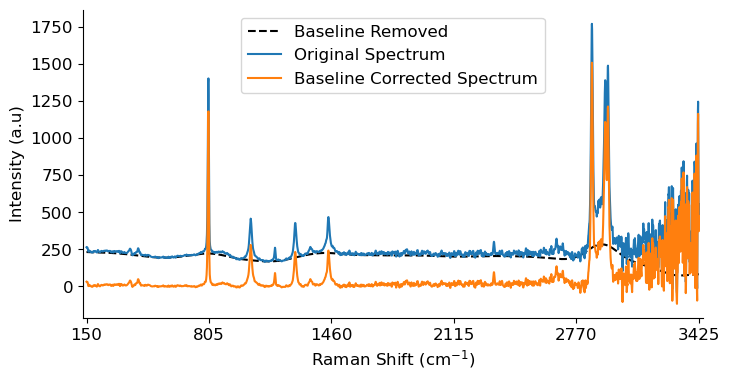

In [9]:
# Estimate the baseline using ALS
als_corrected_spectrum, als_baseline_estimated = als_baseline(low_intensity_sample.to_numpy(), lamda_smooth=1e6, asym_constraint=0.01, niter=10)

_ = build_plot()
plt.plot(als_baseline_estimated, "k--", label="Baseline Removed");
plt.plot(low_intensity_sample, label="Original Spectrum");
plt.plot(als_corrected_spectrum, label="Baseline Corrected Spectrum");
plt.legend();

## Cropping

Here we show how to do some manual cropping and fine-tuning to select the best method and range to retain.
Since cyclohexane is an organic solvent, we want to keep the large wavenumber region.
However, the last few wavelengths that exhibit baseline offset and scattering can be removed.

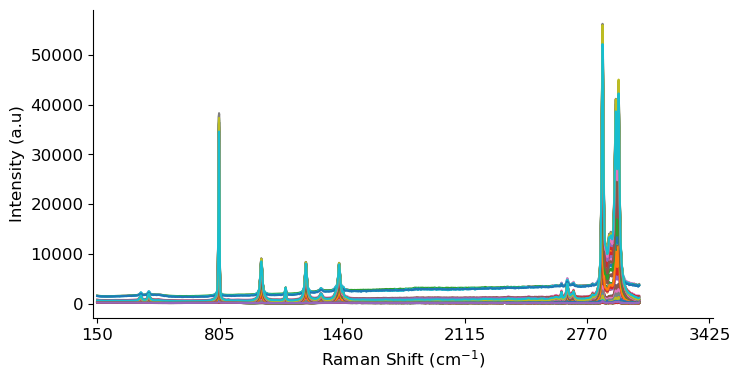

In [10]:
# Example of manual truncation to remove the last 370 (ish) wavenumbers that contain no information
manual_cropping = X.copy().iloc[:, :2900] # here we slice, [:, :2900] for all rows, and columns upto 3050cm-1 (remember index 0 = 150cm-1)

_ = build_plot()
plt.plot(manual_cropping.T);

Or we can wrap some logic in a function with options to crop the spectra based on:
1. Threshold: Keep data above a specified threshold using maximum intensity
2. Peaks: Keep data between the first and last significant peak
3. Range: Keep data within a user-specified wavenumber range

In [11]:
def crop_raman_spectra(wavenumbers, spectra, method='threshold', threshold=0.1, peak_prominence=0.1, range_min=None, range_max=None):
    """
    Automatically truncate Raman spectra for multiple samples.
    
    Parameters:
        wavenumbers (array-like): 
            The x-axis (Raman shift in cm-1), shape (n_wavenumbers,)
        spectra (array-like): 
            The y-axis (intensity values), shape (n_samples, n_wavenumbers)
        method (str): 
            'threshold', 'peaks', or 'range' (default is 'threshold')
        threshold (float): 
            Fraction of max intensity below which data is cropped (for 'threshold' method)
        peak_prominence (float): 
            Minimum peak prominence to consider for truncation (for 'peaks' method)
        range_min (float): 
            Minimum wavenumber to keep (for 'range' method)
        range_max (float): 
            Maximum wavenumber to keep (for 'range' method)
    
    Returns:
        truncated_wavenumbers, truncated_spectra
    """
    spectra = np.asarray(spectra)  # Ensure spectra is a NumPy array
    
    if spectra.ndim == 1:  # Handle single spectrum case
        spectra = spectra.reshape(1, -1)  # Convert to (1, n_wavenumbers)
        
    if method == 'threshold':
        max_intensity = np.max(spectra, axis=1, keepdims=True)
        retain_mask = np.all(spectra >= (threshold * max_intensity), axis=0)
    
    elif method == 'peaks': 
        n_samples, n_wavenumbers = spectra.shape
        retain_mask = np.zeros(n_wavenumbers, dtype=bool)

        peak_indices = []
        for i in range(n_samples):
            peaks, _ = find_peaks(spectra[i], prominence=peak_prominence)
            if len(peaks) > 0:
                peak_indices.append((peaks[0], peaks[-1]))

        if not peak_indices:
            raise ValueError("No peaks found in any spectrum.")
        
        min_idx = min(start for start, _ in peak_indices)
        max_idx = max(end for _, end in peak_indices)
        retain_mask[min_idx:max_idx + 1] = True
    
    elif method == 'range':
        if range_min is None or range_max is None:
            raise ValueError("range_min and range_max must be provided for 'range' method.")
        retain_mask = np.all((wavenumbers >= range_min) & (wavenumbers <= range_max), axis=0)
    
    else:
        raise ValueError("Invalid method. Choose from 'threshold', 'peaks', or 'range'.")

    #print(wavenumbers.shape, retain_mask.shape)
    return wavenumbers[:, retain_mask], spectra[:, retain_mask]

In [12]:
# set up of figure information and samples
xticks = np.linspace(0, X.shape[1]-1, 6, dtype=int)
xlabels = X.columns[xticks].astype(float).astype(int).values

# get the wavenumbers from column names
wavenumbers = X.columns.values.astype(float).reshape(1, -1)

# create a single sample for demonstration
cropping_sample = best_sample.reshape(1, 3276)
plotting_sample = best_sample.reshape(-1)

Number of features retained: 620


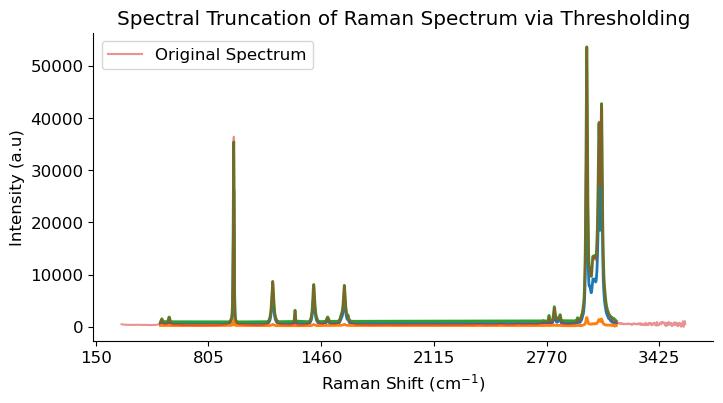

In [13]:
# pass the wavenumbers and the sample to be cropped based on threshold
thresold_cropping, thresold_intensities = crop_raman_spectra(wavenumbers, X, method='threshold', threshold=0.015)
print(f"Number of features retained: {thresold_intensities.shape[-1]}")

fig, ax = plt.subplots(figsize=(8, 4))
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.ylabel("Intensity (a.u)")
plt.xlabel("Raman Shift (cm$^{-1}$)")
plt.xticks(xticks, labels=xlabels)
plt.grid(False)
plt.title("Spectral Truncation of Raman Spectrum via Thresholding")
plt.plot(thresold_cropping[0], thresold_intensities[[1, 10, 102]].T, linewidth=2) # plot random samples
plt.plot(wavenumbers[0], cropping_sample[0], label="Original Spectrum", alpha=0.5)
plt.legend();

Peak prominence is measured based on the intensity units of the spectrum (i.e., max intensity is near 50,000).

Number of features retained: 2558


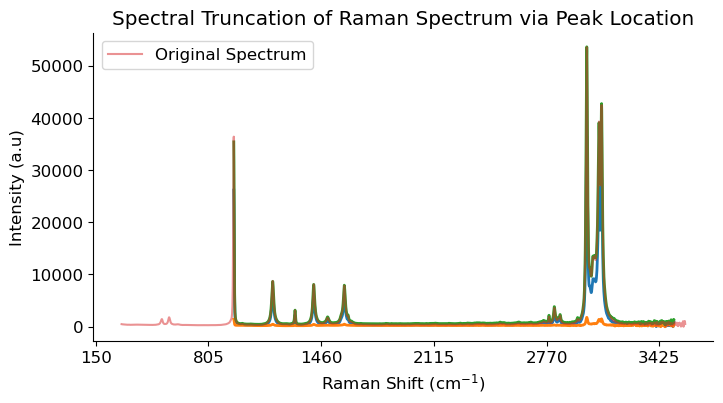

In [14]:
# pass the wavenumbers and the sample to be cropped based on peak location and prominence
peak_cropping, peak_intensities = crop_raman_spectra(wavenumbers, X, method='peaks', peak_prominence=1640)
print(f"Number of features retained: {peak_intensities.shape[1]}")

fig, ax = plt.subplots(figsize=(8, 4))
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.ylabel("Intensity (a.u)")
plt.xlabel("Raman Shift (cm$^{-1}$)")
plt.xticks(xticks, labels=xlabels)
plt.grid(False)
plt.plot(peak_cropping[0], peak_intensities[[1, 10, 102]].T, linewidth=2) # plot random samples
plt.plot(wavenumbers[0], cropping_sample[0], label="Original Spectrum", alpha=0.5)
plt.title("Spectral Truncation of Raman Spectrum via Peak Location")
plt.legend();

Number of features retained: 2558


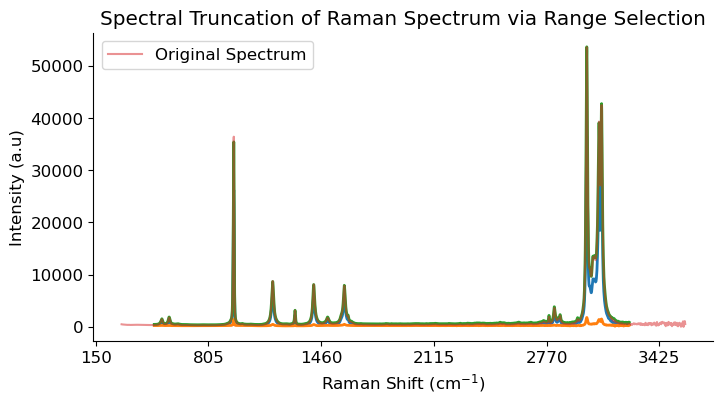

In [15]:
# pass the wavenumbers and the sample to be cropped based on user-defined range
range_cropping, range_intensities = crop_raman_spectra(wavenumbers, X, method='range', range_min=340, range_max=3100)
print(f"Number of features retained: {peak_intensities.shape[1]}")

fig, ax = plt.subplots(figsize=(8, 4))
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.ylabel("Intensity (a.u)")
plt.xlabel("Raman Shift (cm$^{-1}$)")
plt.xticks(xticks, labels=xlabels)
plt.grid(False)
plt.plot(range_cropping[0], range_intensities[[1, 10, 102]].T, linewidth=2) # plot random samples
plt.plot(wavenumbers[0], cropping_sample[0], label="Original Spectrum", alpha=0.5)
plt.title("Spectral Truncation of Raman Spectrum via Range Selection")
plt.legend();